In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('BTC.csv')

In [3]:
df = df.iloc[2359:]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2039 entries, 2359 to 4397
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2039 non-null   object 
 1   Price     2039 non-null   float64
 2   Open      2039 non-null   float64
 3   High      2039 non-null   float64
 4   Low       2039 non-null   float64
 5   Vol.      2039 non-null   int64  
 6   Change %  2039 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 111.6+ KB


In [5]:
def set_seq(seq, seq_len):
    X = []
    y = []
    for t in range(len(seq)-seq_len):
        end = t + seq_len 
        
        if end> len(seq)-1:
            break
        
        Xseq= seq[t:end, :-1]
        y_target =seq[end, -1]
        X.append(Xseq)
        y.append(y_target)
    return np.array(X), np.array(y) #initializing the arrays

In [6]:
X = df.drop(['Date', 'Price', 'Change %'], axis=1).values
Y = df['Price'].values

In [7]:
seq_len= 30
train_count = 179
X_train= X[:-train_count]
y_train= Y[:-train_count]
X_test= X[-train_count:]
y_test= Y[-train_count:]
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

In [8]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1860, 4) (1860, 1)
(179, 4) (179, 1)


In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train)

In [10]:
df_train = np.hstack((X_train,y_train))
X_train_seq, y_train_seq = set_seq(df_train, seq_len)
features_num = X_train_seq.shape[2]

In [11]:
print(X_train_seq.shape)
y_train_seq.shape

(1830, 30, 4)


(1830,)

In [12]:
no_sub_seq=3
sub_seq_len=10
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], no_sub_seq, 1, sub_seq_len, features_num))
X_train_seq.shape

(1830, 3, 1, 10, 4)

In [13]:
import tensorflow as tf

tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.he_uniform(seed=0)

Lstm_model = tf.keras.models.Sequential()
Lstm_model.add(tf.keras.layers.ConvLSTM2D(filters=128, kernel_size=(1,2), activation='relu', input_shape=(no_sub_seq,1, sub_seq_len, features_num)))
Lstm_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
Lstm_model.add(tf.keras.layers.Dense(1,activation='linear'))

In [14]:
# opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
Lstm_model.compile(optimizer=opt, loss='mse')
Lstm_model.fit( X_train_seq, y_train_seq, epochs=60, batch_size=25, shuffle=False)

Epoch 1/60
74/74 [==============================] - 8s 28ms/step - loss: 0.0068
Epoch 2/60
74/74 [==============================] - 2s 31ms/step - loss: 0.0055
Epoch 3/60
74/74 [==============================] - 1s 19ms/step - loss: 0.0035
Epoch 4/60
74/74 [==============================] - 2s 29ms/step - loss: 0.0031
Epoch 5/60
74/74 [==============================] - 1s 17ms/step - loss: 0.0032
Epoch 6/60
74/74 [==============================] - 2s 27ms/step - loss: 0.0041
Epoch 7/60
74/74 [==============================] - 1s 19ms/step - loss: 0.0062
Epoch 8/60
74/74 [==============================] - 2s 26ms/step - loss: 0.0090
Epoch 9/60
74/74 [==============================] - 2s 29ms/step - loss: 0.0116
Epoch 10/60
74/74 [==============================] - 1s 19ms/step - loss: 0.0088
Epoch 11/60
74/74 [==============================] - 2s 29ms/step - loss: 0.0062
Epoch 12/60
74/74 [==============================] - 1s 18ms/step - loss: 0.0044
Epoch 13/60
74/74 [==================

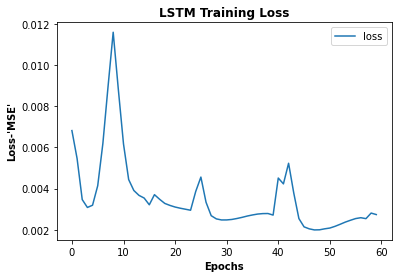

In [15]:
# Training loss plot
loss = pd.DataFrame(Lstm_model.history.history)
loss.plot()
plt.title('LSTM Training Loss',fontweight='bold')
plt.xlabel('Epochs',fontweight='bold')
plt.ylabel("Loss-'MSE'",fontweight='bold');

In [16]:
train_lstm_outputs = []

for i in range(X_train_seq.shape[0]):
    train_lstm_outputs.append(Lstm_model.predict(X_train_seq[i].reshape((1, no_sub_seq, 1, sub_seq_len, features_num)))[0,0])



In [17]:
predicted_values = scaler.inverse_transform(train_lstm_outputs).reshape((-1,1))
y_train_seq=scaler.inverse_transform(y_train_seq.reshape(-1, 1))

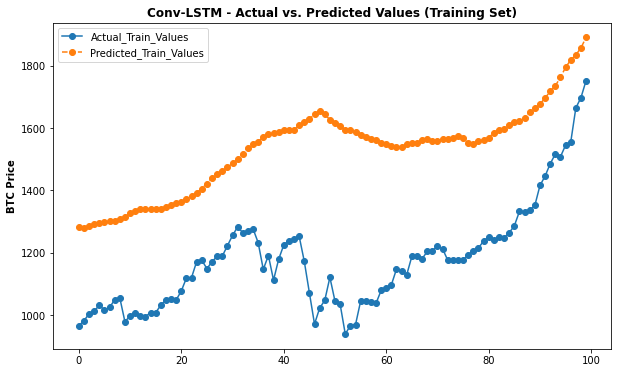

In [18]:
plt.figure(figsize=(10,6))
plt.plot(y_train_seq[:100],marker='o',linestyle='-')

plt.plot(predicted_values[:100],marker='o',linestyle='dashed')
plt.title('Conv-LSTM - Actual vs. Predicted Values (Training Set)',fontweight='bold')
plt.legend(('Actual_Train_Values','Predicted_Train_Values'))
plt.ylabel('BTC Price',fontweight='bold');

Text(0.5, 1.0, 'Kernel Density Estimation ')

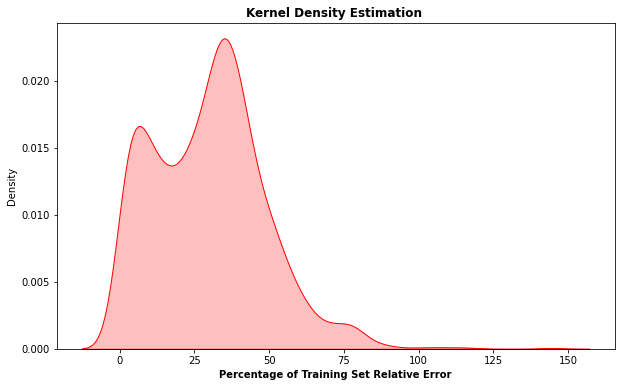

In [19]:
vanilla_trainset_error = abs((y_train_seq-predicted_values)/y_train_seq)*100
vanilla_trainset_error = pd.DataFrame(vanilla_trainset_error,columns=['Training Set Error'])
plt.figure(figsize=(10,6))
sns.kdeplot(vanilla_trainset_error['Training Set Error'],shade=True,color='r',kernel='gau',)
plt.xlabel('Percentage of Training Set Relative Error',fontweight='bold')
plt.title('Kernel Density Estimation ',fontweight='bold')

In [20]:
vanilla_trainset_error.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Training Set Error,1830.0,29.818296,18.886489,0.003948,13.945371,30.713982,41.018353,144.500986


In [21]:
RMSE=np.sqrt(mean_squared_error(y_train_seq,predicted_values))
RMSE=RMSE.round(2)
RMSE

3132.41

In [22]:
X_test_seq = []
a = np.concatenate((X_train[-29:], X_test), axis=0)
for i in range(179):
    X_test_seq.append(a[i:i+30])
X_test_seq = np.array(X_test_seq)

In [23]:
lstm_outputs = []

for i in range(len(X_test_seq)):
    lstm_outputs.append( Lstm_model.predict(X_test_seq[i].reshape(1,no_sub_seq, 1, sub_seq_len, features_num))[0,0]) 

In [24]:
predicted_test_values = scaler.inverse_transform(lstm_outputs)

Text(0, 0.5, 'BTC Price')

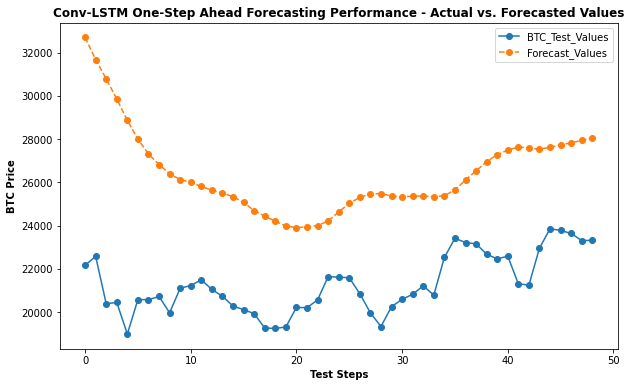

In [25]:
plt.figure(figsize=(10,6))
plt.plot(y_test[130:],marker='o',linestyle='-')
plt.plot(predicted_test_values[130:],marker='o',linestyle='dashed')
plt.title('Conv-LSTM One-Step Ahead Forecasting Performance - Actual vs. Forecasted Values',fontweight='bold')
plt.legend(('BTC_Test_Values','Forecast_Values'))
plt.xlabel('Test Steps',fontweight='bold')
plt.ylabel('BTC Price',fontweight='bold')

Text(0.5, 1.0, 'Kernel Density Estimation ')

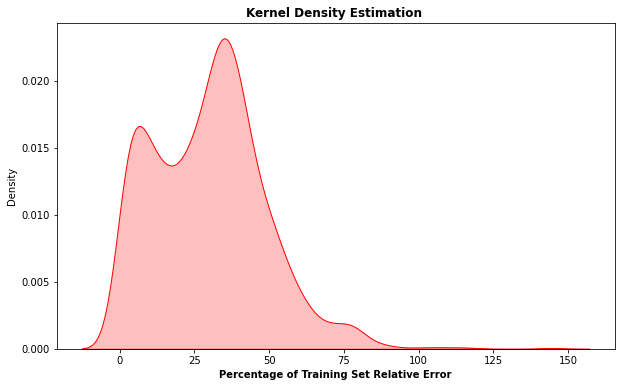

In [26]:
trainset_error = abs((y_test-predicted_test_values)/y_test)*100
trainset_error = pd.DataFrame(vanilla_trainset_error,columns=['Training Set Error'])
plt.figure(figsize=(10,6))
sns.kdeplot(vanilla_trainset_error['Training Set Error'],shade=True,color='r',kernel='gau',)
plt.xlabel('Percentage of Training Set Relative Error',fontweight='bold')
plt.title('Kernel Density Estimation ',fontweight='bold')

In [27]:
trainset_error.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Training Set Error,1830.0,29.818296,18.886489,0.003948,13.945371,30.713982,41.018353,144.500986


In [28]:
RMSE=np.sqrt(mean_squared_error(y_test,predicted_test_values))
RMSE=RMSE.round(2)
RMSE

997951.78